# Loading images

In [1]:
from PIL import Image
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import math;

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader,TensorDataset
from torchvision import transforms

from torchsummary import summary
%matplotlib inline

In [2]:
train_images = pickle.load(open("pkl/preprocessed_train_images.pkl", "rb"))
train_labels = pickle.load(open("pkl/train_labels.pkl", "rb"))
train_filenames = pickle.load(open("pkl/train_filenames.pkl", "rb"))
test_images = pickle.load(open("pkl/preprocessed_test_images.pkl", "rb"))
test_filenames = pickle.load(open("pkl/test_filenames.pkl", "rb"))

Average width 64.0 , Average height: 64.0


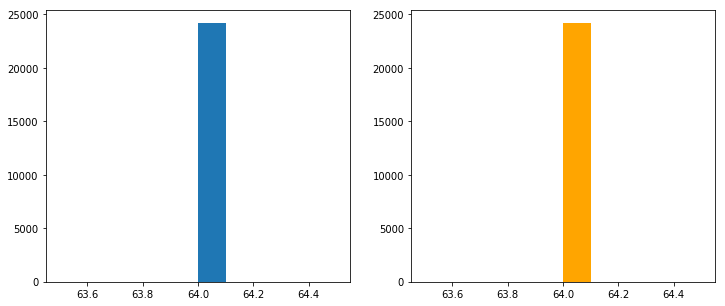

In [3]:
#PIL

widths, heights = [], [] 
sumx, sumy = 0, 0
for i in train_images:
    sumx += i.size[0]
    widths.append(i.size[0])
    sumy += i.size[1]
    heights.append(i.size[1])


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(widths)
ax2.hist(heights, color = 'orange')
fig.set_size_inches(12, 5)

avg_width = np.mean(widths)
avg_height = np.mean(heights)
print('Average width {} , Average height: {}'.format(avg_width, avg_height))

In [4]:
class ListsTrainDataset(Dataset):
    def __init__(self, list_of_images, list_of_labels, transform=None):
        """
        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
#         super().__init__()
        self.data = list_of_images
        self.labels = np.asarray(list_of_labels).reshape(-1,1)
        self.transform = transform

    def __getitem__(self, index):
        single_image = self.data[index]
        single_image_label = self.labels[index]
        # Transform image to tensor
        if self.transform is not None:
            img_as_tensor = self.transform(single_image)
        # Return image and the label
        return (img_as_tensor, single_image_label)

    def __len__(self):
        return len(self.data)

In [5]:
class ListsTestDataset(Dataset):
    def __init__(self, list_of_images, transform=None):
        """
        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data = list_of_images
        self.transform = transform

    def __getitem__(self, index):
        single_image = self.data[index]
        if self.transform is not None:
            img_as_tensor = self.transform(single_image)
        # Return image ONLY
        return img_as_tensor

    def __len__(self):
        return len(self.data)

In [6]:
#Transforms and Dataset Creation
def create_datasets_dataloaders(X_train, y_train, X_test= None, y_test = None):
    test_transforms = transforms. Compose([
        transforms.Grayscale(),
        transforms.ToTensor()
    ])
    
    train_transforms = transforms. Compose([
        transforms.Grayscale(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=360),
        transforms.ToTensor()
    ])
    
    train_dataset = ListsTrainDataset(X_train, y_train, transform = train_transforms)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers=2)

    if y_test is not None:
        test_dataset = ListsTrainDataset(X_test, y_test, transform = test_transforms)
    else:
        test_dataset = ListsTestDataset(X_test, transform = test_transforms)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)
    return (train_loader, test_loader)

In [7]:
from torchvision.models.resnet import BasicBlock, Bottleneck, ResNet

In [8]:
def train(model, data_loader, num_epochs):
    learning_rate = 0.0005
    batch_size = data_loader.batch_size
    criterion = nn.CrossEntropyLoss();
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
#     optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate);
    #Training
    history = {'batch': [], 'loss': [], 'accuracy': []}
    for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(data_loader):
                images = Variable(images).cuda()
                labels = Variable(labels).squeeze(1).long().cuda()#.cpu()
                # Forward + Backward + Optimize
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                _, argmax = torch.max(outputs, 1)
                accuracy_train = (labels == argmax.squeeze()).float().mean()*100
                # Show progress
                if (i+1) % 32 == 0:
                    log = " ".join([
                      "Epoch : %d/%d" % (epoch+1, num_epochs),
                      "Iter : %d/%d" % (i+1, len(data_loader.dataset)//batch_size),
                      "Loss: %.4f" % loss.item(),
                      "Accuracy: %.4f" % accuracy_train])
                    print('\r{}'.format(log), end='')
                    history['batch'].append(i)
                    history['loss'].append(loss.item())
                    history['accuracy'].append(accuracy_train.item())
            print()
    return model

In [9]:
# cnn.eval().cuda()
# correct = 0
# total = 0
# for images, labels in test_loader:
#     images = Variable(images)
#     labels= labels.squeeze(1)
#     outputs = cnn(images)
#     _, predicted = torch.max(outputs.data, 1)
#     total += labels.size(0)
#     correct += (predicted.float() == labels).sum()
# print('Test Accuracy of the model on the 60000 test images: %.4f %%' % (100*correct.item() / total))

In [10]:
def predict_test_set(model, loader, filenames):
    predictions = []
    for images in loader:
        images = Variable(images).cuda()
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        predictions.extend(prediction.cpu().numpy())
    results_df = pd.DataFrame({'image': test_filenames, 'class': predictions}, columns=['image', 'class'])
    results_df.to_csv('results.csv',sep = ',', index = False)

In [11]:
# train_loader, test_loader = create_datasets_dataloaders(train_images, train_labels)
# cnn = ResNetMine(Bottleneck, [1, 1, 1, 1]).cuda()
# trained_model = train(cnn, train_loader, num_epochs=20)

In [12]:
##predict on testset

# test_transforms = transforms. Compose([
#         transforms.CenterCrop(64),
#         transforms.ToTensor()
#     ])

# test_dataset = ListsTestDataset(test_images, transform = test_transforms)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = False)

# predict_test_set(trained_model, test_loader, test_filenames)

In [13]:
def train_and_validate(model, train_loader, test_loader, num_epochs):
    learning_rate = 0.0001
    weight_decay = 0.00005
    batch_size = train_loader.batch_size
    criterion = nn.CrossEntropyLoss();
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay);
#     optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate);
    #Training
    history = {'batch': [], 'loss': [], 'accuracy': []}
    for epoch in range(num_epochs):
        model.train().cuda()
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images).cuda()
            labels = Variable(labels).squeeze(1).long().cuda()#.cpu()
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, argmax = torch.max(outputs, 1)
            accuracy_train = (labels == argmax.squeeze()).float().mean()*100
            # Show progress
            if (i+1) % 32 == 0:
                log = " ".join([
                  "Epoch : %d/%d" % (epoch+1, num_epochs),
                  "Iter : %d/%d" % (i+1, len(train_loader.dataset)//batch_size),
                  "Loss: %.4f" % loss.item(),
                  "Accuracy: %.4f" % accuracy_train])
                print('\r{}'.format(log), end='')
                history['batch'].append(i)
                history['loss'].append(loss.item())
                history['accuracy'].append(accuracy_train.item())
        print()
        ##VALIDATION SCORE AFTER EVERY EPOCH
        model.eval().cuda()
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = Variable(images).cuda()
            labels= labels.squeeze(1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu().long() == labels).sum()
        print('VALIDATION SET ACCURACY: %.4f %%' % (100*correct.item() / total))
    return model

## KFolds

In [14]:
import importlib
import NNs
import math

In [16]:
importlib.reload(NNs)
from NNs import *
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, random_state=None, shuffle=True)
trained_models = []
for train_indexes, validation_indexes in kf.split(train_images):
    X_train = []
    y_train = []
    X_val = []
    y_val = []
    
    for i in train_indexes:
        X_train.append(train_images[i])
        y_train.append(train_labels[i])
    for j in validation_indexes:
        X_val.append(train_images[j])
        y_val.append(train_labels[j])
    train_loader, test_loader = create_datasets_dataloaders(
        X_train, y_train, X_val, y_val)
    
    #Training
#     cnn = ResNetMine(BasicBlock, [1, 1, 1, 1]).cuda()
    cnn = CNN().cuda()

#     print(summary(cnn, (1,28,28)))
    trained_model = train_and_validate(cnn, train_loader, test_loader, num_epochs=150)
    trained_models.append(trained_model)

RuntimeError: size mismatch, m1: [32 x 5120], m2: [980 x 250] at /opt/conda/conda-bld/pytorch_1535491974311/work/aten/src/THC/generic/THCTensorMathBlas.cu:249

In [19]:
trained_models[0]

ResNetMine(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2)

In [19]:
# cnn2 = trained_models[1]
# cnn2.fc.weight

cnn = ResNetMine(Bottleneck, [1, 1, 1]).cuda()
summary(cnn, (1,28,28))

RuntimeError: Given input size: (1024x2x2). Calculated output size: (1024x0x0). Output size is too small at /opt/conda/conda-bld/pytorch_1535491974311/work/aten/src/THCUNN/generic/SpatialAveragePooling.cu:63